Estimating empirical error terms

In [15]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt
%matplotlib inline

In [2]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

In [3]:
spx['daily_chg'] = spx['Adj Close'].pct_change()

In [166]:
df, loc, scale = stats.t.fit(spx['daily_chg'][1500:])
df_all, loc_all, scale_all = stats.t.fit(spx['daily_chg'][1:])
loc_norm, scale_norm = stats.norm.fit(spx['daily_chg'][1:])

In [5]:
normal_sample =  stats.norm.rvs(loc_norm, scale_norm, size=10000000)

In [6]:
sample = stats.t.rvs(df, loc, scale, size=10000000)
sample_all = stats.t.rvs(df_all, loc_all, scale_all, size=10000000)

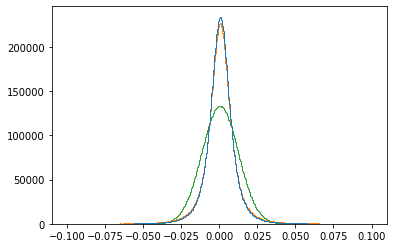

In [23]:
plt.hist(x=(sample, sample_all, normal_sample), bins=500, range=[-0.1, .1], histtype='step')
plt.show()

Simulating market with t-distributions

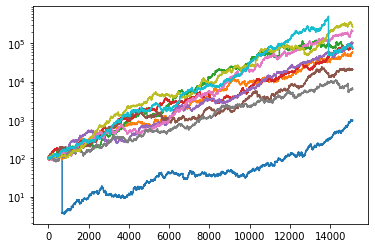

In [48]:
years = 60
t_days = 252

market = np.empty((t_days*years, 100))

num_sims = 10

for j in range(num_sims):
    market_sample = stats.t.rvs(df, loc, scale, size=t_days*years)
    market[0, j] = 100
    for i, err in enumerate(market_sample, start=1):
        if i < (t_days*years):
            market[i, j] = market[i-1, j]*(1+err)
        

plt.plot(market[:, 0:num_sims])
plt.yscale('log')
plt.show()

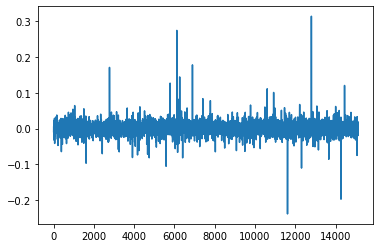

In [42]:
plt.plot(market_sample)
plt.show()

In [19]:
(market[-1, 0]/market[0, 0])**(1/60)-1

0.13534954365356566

Fitting GARCH model

In [8]:
model=arch.arch_model(spx['daily_chg'][1500:]*100, vol='Garch', p=1, o=1, q=1, dist='skewt')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 187539.0593966213
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1469363.2223410273
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7656820.648569918
Iteration:      4,   Func. Count:     43,   Neg. LLF: 34527.7031382407
Iteration:      5,   Func. Count:     52,   Neg. LLF: 34041.14938680757
Iteration:      6,   Func. Count:     61,   Neg. LLF: 367398.66531061137
Iteration:      7,   Func. Count:     70,   Neg. LLF: 472190.0798028305
Iteration:      8,   Func. Count:     80,   Neg. LLF: 27040.03512842727
Iteration:      9,   Func. Count:     89,   Neg. LLF: 32103.377552024576
Iteration:     10,   Func. Count:     98,   Neg. LLF: 26892.26256215066
Iteration:     11,   Func. Count:    107,   Neg. LLF: 26782.496324634092
Iteration:     12,   Func. Count:    116,   Neg. LLF: 27127.4963021987
Iteration:     13,   Func. Count:    126,   Neg. LLF: 26789.291946962934
Iteration:     14,   Func. Count:    135,   Neg. LLF: 26763.2

In [159]:
model=arch.arch_model(spx['daily_chg'][1:]*100, vol='Garch', p=1, o=0, q=1, dist='studentst')
results=model.fit()
print(results.summary())
resid = results.resid

Iteration:      1,   Func. Count:      7,   Neg. LLF: 485092.2232944491
Iteration:      2,   Func. Count:     20,   Neg. LLF: 218460.2007044941
Iteration:      3,   Func. Count:     28,   Neg. LLF: 171703.48661716378
Iteration:      4,   Func. Count:     36,   Neg. LLF: 30237.090449597683
Iteration:      5,   Func. Count:     43,   Neg. LLF: 30222.78063572674
Iteration:      6,   Func. Count:     50,   Neg. LLF: 30558.196386793923
Iteration:      7,   Func. Count:     57,   Neg. LLF: 48845.62103593092
Iteration:      8,   Func. Count:     65,   Neg. LLF: 30075.586806352112
Iteration:      9,   Func. Count:     71,   Neg. LLF: 30093.552641754537
Iteration:     10,   Func. Count:     78,   Neg. LLF: 35506.238271811686
Iteration:     11,   Func. Count:     86,   Neg. LLF: 30069.961765564392
Iteration:     12,   Func. Count:     93,   Neg. LLF: 30069.030934062408
Iteration:     13,   Func. Count:    100,   Neg. LLF: 30066.975971392385
Iteration:     14,   Func. Count:    106,   Neg. LLF: 3

In [108]:
market_sample = []
t_days = 252
year = 5
period = t_days*year

forecasts = results.forecast(horizon=period, method='bootstrap', simulations=1, start=period/.2)

sims = forecasts.simulations
sims = [sim[0]/100 for sim in sims.values[-1,:,:].T]
market_sample.extend(sims)

#lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=1)
#plt.show()


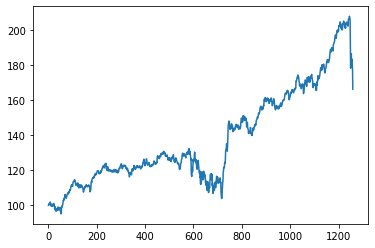

In [109]:
market = np.empty((period, 100))

num_sims = 1

trend = 1.000
for j in range(num_sims):
    #market_sample = stats.t.rvs(df, loc, scale, size=252*years)
    market[0, j] = 100
    for i, err in enumerate(market_sample, start=1):
        if i < (period):
            market[i, j] = market[i-1, j]*(1+err)
        
plt.plot(market[:, 0:num_sims])
#plt.yscale('log')
plt.show()

In [110]:
diff = pd.DataFrame(market_sample)

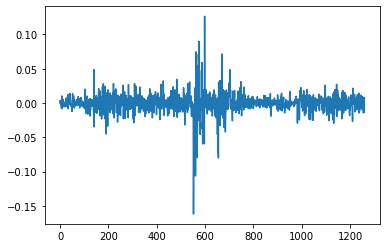

In [105]:
plt.plot(diff)
plt.show()

In [57]:
diff.describe()

,0
count,2520.000000
mean,0.000298
std,0.008583
min,-0.052814
25%,-0.003999
50%,0.000564
75%,0.004924
max,0.049376


Manual GARCH forecast

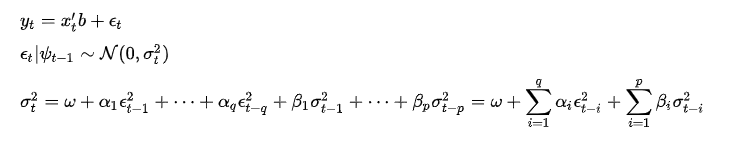

In [ ]:
def y_t(b, epsilon):
    return b+epsilon

def epsilon_t(sigma):
    stats.t.rvs(v, )
    
def sigma_t(omega, alpha, beta, q, p, sigma_t_minus_1, epsilon_t_minus_1):
    
    
def alpha_term(alpha, q, epsilon_t_minus_1):
    for each i in q:
        alpha

In [161]:
model=arch.arch_model(spx['daily_chg'][1:]*100, vol='Garch', p=1, o=0, q=1, dist='studentst')
results=model.fit()
#print(results.summary())
resid = results.resid

Iteration:      1,   Func. Count:      7,   Neg. LLF: 485092.2232944491
Iteration:      2,   Func. Count:     20,   Neg. LLF: 218460.2007044941
Iteration:      3,   Func. Count:     28,   Neg. LLF: 171703.48661716378
Iteration:      4,   Func. Count:     36,   Neg. LLF: 30237.090449597683
Iteration:      5,   Func. Count:     43,   Neg. LLF: 30222.78063572674
Iteration:      6,   Func. Count:     50,   Neg. LLF: 30558.196386793923
Iteration:      7,   Func. Count:     57,   Neg. LLF: 48845.62103593092
Iteration:      8,   Func. Count:     65,   Neg. LLF: 30075.586806352112
Iteration:      9,   Func. Count:     71,   Neg. LLF: 30093.552641754537
Iteration:     10,   Func. Count:     78,   Neg. LLF: 35506.238271811686
Iteration:     11,   Func. Count:     86,   Neg. LLF: 30069.961765564392
Iteration:     12,   Func. Count:     93,   Neg. LLF: 30069.030934062408
Iteration:     13,   Func. Count:    100,   Neg. LLF: 30066.975971392385
Iteration:     14,   Func. Count:    106,   Neg. LLF: 3

In [162]:
df, loc, scale = stats.t.fit(resid)

In [163]:
dist = stats.t.rvs(df, loc, scale, size = 10000000)

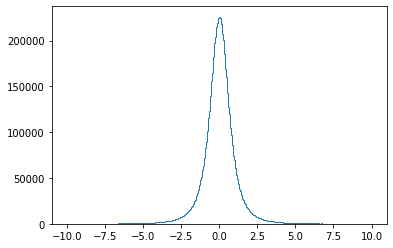

In [164]:
plt.hist(x=dist, bins= 500, histtype='step', range=[-10, 10])
plt.show()

In [165]:
df, loc, scale

(2.4724001880267243, -0.010742450853425647, 0.6395158720156087)